In [1]:
# Model Development – REGRESSION
# Predict Avg_Speed using mobility data + aggregated PABT volumes
# INPUTS:
#   - Merged_Traffic_Mobility_Data_Full.csv
#       ['Facility_Name','Month_Year','Aggregated_Traffic_Volume','Freeflow','Avg_Speed','Direction','Delta']
#   - Merged_PABT_Bus_Passenger_For_Predictive.csv
#       ['Start_Date','End_Date','Carrier_clean','Volume_Bus','Volume_Passenger','log_Volume_Bus','log_Volume_Passenger',
#        'Volume_Bus_capped','Volume_Passenger_capped','bus_zero','pass_zero','bus_z','pass_z','bus_zero_rate']
#
# ARTIFACTS: artifacts_regression/{model}.joblib, feature_importances.csv, summary.json

import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

MOBILITY_CSV = "Merged_Traffic_Mobility_Data_Full.csv"
PABT_CSV     = "Merged_PABT_Bus_Passenger_For_Predictive.csv"
ARTI_DIR     = "artifacts_regression"
os.makedirs(ARTI_DIR, exist_ok=True)

In [3]:
# ---------- Load ----------
mob = pd.read_csv(MOBILITY_CSV)
pabt = pd.read_csv(PABT_CSV)

In [11]:
# Parse dates / months
# ----------- Load -----------
mob = pd.read_csv(MOBILITY_CSV)
pabt = pd.read_csv(PABT_CSV)

# ----------- Parse dates -----------
mob['Month_Year'] = pd.to_datetime(mob['Month_Year'], errors='coerce')

# Try with correct format (edit as per your dataset)
pabt['Start_Date'] = pd.to_datetime(pabt['Start_Date'], format='%Y-%m-%d', errors='coerce')

# Convert to Month_Year precision
pabt['Month_Year'] = pabt['Start_Date'].dt.to_period('M').dt.to_timestamp()


In [5]:
# Aggregate PABT by month (use capped totals to be robust to outliers if present)
pabt_month = (
    pabt.groupby('Month_Year', as_index=False)[['Volume_Bus_capped','Volume_Passenger_capped']].sum()
      .rename(columns={'Volume_Bus_capped':'Bus_Vol_Month','Volume_Passenger_capped':'Pass_Vol_Month'})
)

In [6]:

# Join onto mobility
df = mob.merge(pabt_month, on='Month_Year', how='left')
df[['Bus_Vol_Month','Pass_Vol_Month']] = df[['Bus_Vol_Month','Pass_Vol_Month']].fillna(0)

In [7]:
# Choose features/target
target_col = 'Avg_Speed'
num_cols = ['Freeflow','Aggregated_Traffic_Volume','Delta','Bus_Vol_Month','Pass_Vol_Month']
cat_cols = ['Facility_Name','Direction']


In [8]:
df = df.dropna(subset=[target_col]).copy()
X = df[num_cols + cat_cols].copy()
y = df[target_col].copy()

In [9]:
# ---------- Preprocess ----------
numeric_tf = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
categorical_tf = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore'))])
pre = ColumnTransformer([('num', numeric_tf, num_cols),
                         ('cat', categorical_tf, cat_cols)])

In [13]:
# ---------- Models (edit to match your AutoML hyperparams if known) ----------
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def safe_rmse(y_true, y_pred):
    try:
        # new sklearn
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # old sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))

results = {}

for name, model in candidates.items():
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    metrics = {
        'MAE': float(mean_absolute_error(y_test, y_hat)),
        'RMSE': float(safe_rmse(y_test, y_hat)),
        'R2' : float(r2_score(y_test, y_hat))
    }

    # CV on R2
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='r2')
    metrics['CV_R2_mean'] = float(np.mean(cv_scores))
    metrics['CV_R2_std']  = float(np.std(cv_scores))

    # Save pipeline
    pth = os.path.join(ARTI_DIR, f'{name}.joblib')
    joblib.dump(pipe, pth)

    # Feature importances (if supported)
    try:
        fitted = pipe.named_steps['model']
        if hasattr(fitted, 'feature_importances_'):
            # get OHE feature names across sklearn versions
            ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
            try:
                cat_out = list(ohe.get_feature_names_out(cat_cols))  # new API
            except AttributeError:
                cat_out = list(ohe.get_feature_names(cat_cols))      # old API
            final_names = num_cols + cat_out
            importances = (pd.DataFrame({
                'feature': final_names,
                'importance': fitted.feature_importances_
            }).sort_values('importance', ascending=False))
            importances.to_csv(os.path.join(ARTI_DIR, f'{name}_feature_importances.csv'), index=False)
    except Exception:
        pass

    results[name] = {
        'hyperparams': str(model.get_params()),
        'metrics': metrics,
        'artifact': pth
    }

with open(os.path.join(ARTI_DIR, 'summary.json'), 'w') as f:
    json.dump(results, f, indent=2)

print("REGRESSION RESULTS\n", json.dumps(results, indent=2))



REGRESSION RESULTS
 {
  "RandomForestRegressor": {
    "hyperparams": "{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",
    "metrics": {
      "MAE": 0.15505001905085983,
      "RMSE": 1.064340935380227,
      "R2": 0.9942616899203176,
      "CV_R2_mean": 0.9948269724445657,
      "CV_R2_std": 0.002849364857784774
    },
    "artifact": "artifacts_regression\\RandomForestRegressor.joblib"
  },
  "GradientBoostingRegressor": {
    "hyperparams": "{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity

In [14]:
import json
with open("artifacts_regression/summary.json", "r") as f:
    results = json.load(f)
pd.DataFrame({k: v["metrics"] for k, v in results.items()}).T


,MAE,RMSE,R2,CV_R2_mean,CV_R2_std
RandomForestRegressor,0.155050,1.064341,0.994262,0.994827,0.002849
GradientBoostingRegressor,0.156121,1.071270,0.994187,0.994387,0.003048
ElasticNet,0.123393,1.018385,0.994747,0.997138,0.003111


Matplotlib is building the font cache; this may take a moment.
C:\Users\karki\AppData\Local\Temp\ipykernel_45932\1602001713.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='MAE', data=results_df, palette=palette)
C:\Users\karki\AppData\Local\Temp\ipykernel_45932\1602001713.py:23: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(ax=axes[0], x='Model', y='MAE', data=results_df, palette=palette)
C:\Users\karki\AppData\Local\Temp\ipykernel_45932\1602001713.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='RMSE', data=results_df, palette=palette)
C:\Users\karki\AppData\Local\Te

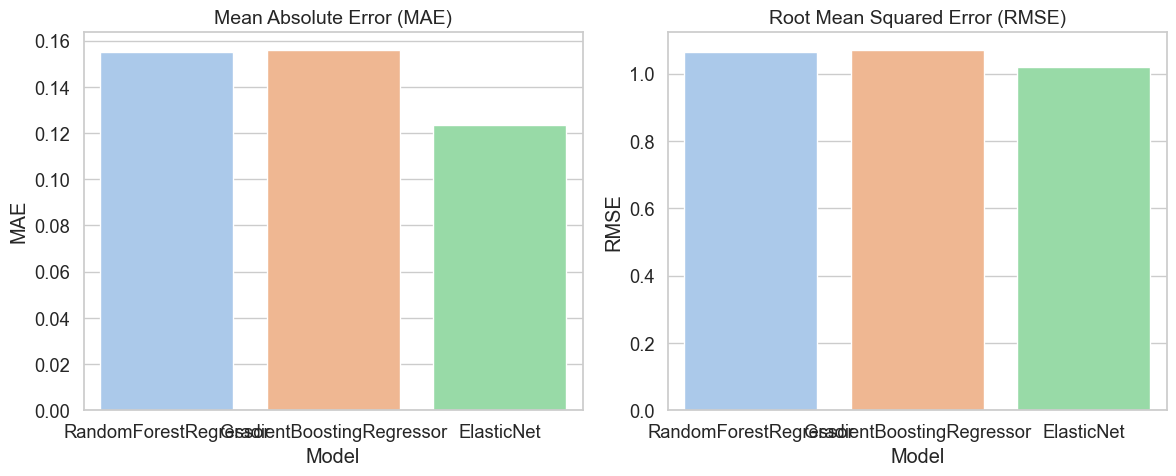

C:\Users\karki\AppData\Local\Temp\ipykernel_45932\1602001713.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette="pastel")


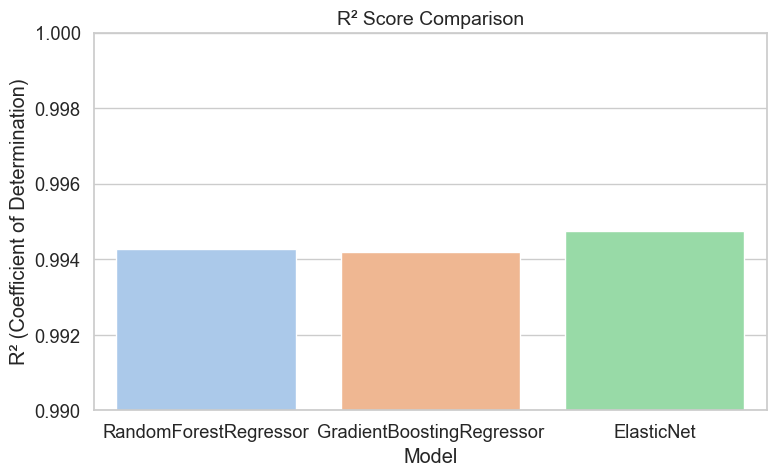

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming your results DataFrame is named `results_df`
# If not, replace it with your actual DataFrame name
results_df = pd.DataFrame({
    'Model': ['RandomForestRegressor', 'GradientBoostingRegressor', 'ElasticNet'],
    'MAE': [0.155050, 0.156121, 0.123393],
    'RMSE': [1.064341, 1.071270, 1.018385],
    'R2': [0.994262, 0.994187, 0.994747],
    'CV_R2_mean': [0.994827, 0.994387, 0.997138],
    'CV_R2_std': [0.002849, 0.003048, 0.003111]
})

# --- Style setup ---
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("pastel")

# --- Plot 1: MAE and RMSE side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(ax=axes[0], x='Model', y='MAE', data=results_df, palette=palette)
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14)
axes[0].set_ylabel('MAE')

sns.barplot(ax=axes[1], x='Model', y='RMSE', data=results_df, palette=palette)
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
axes[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

# --- Plot 2: R² comparison ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2', data=results_df, palette="pastel")
plt.title('R² Score Comparison', fontsize=14)
plt.ylabel('R² (Coefficient of Determination)')
plt.ylim(0.99, 1.00)
plt.tight_layout()
plt.show()
